In [15]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from scipy.stats import truncnorm


In [16]:
class Generate_Network:
    def __init__(self, num_agents, p_edge, p,
                 random_rels=False, beta_rels=False, peer_rels=True,
                 beta_a=2, beta_b=5,
                 density=False, betweenness=False,
                 ws=True, rn=False, sf=False, sblock= False,
                 ground_truth=0.7, max_rel = 0.8):

        self.num_agents = num_agents
        self.p_edge = p_edge
        self.p = p
        self.random_rels = random_rels
        self.beta_rels = beta_rels
        self.peer_rels = peer_rels
        self.beta_a = beta_a
        self.beta_b = beta_b
        self.density = density
        self.betweenness = betweenness
        self.special_node_index = None
        self.ws = ws
        self.rn = rn
        self.sf = sf
        self.sblock = sblock
        self.ground_truth = ground_truth
        self.max_rel = max_rel

        self.G = self._generate_connected_graph()
        self._adjust_graph(density=density, betweenness=betweenness)

        self.neighbors = self._build_neighbor_index_array()
        self.agents = self._build_agents()

    def _generate_connected_graph(self):
        expected_edges = int(self.num_agents * (self.num_agents - 1) * self.p_edge / 2)
        if self.ws:
            while True:
                k_neighbors = (2 * expected_edges) // self.num_agents
                G = nx.watts_strogatz_graph(n=self.num_agents, k=k_neighbors, p=self.p)
                if nx.is_connected(G):
                    return G
        elif self.rn:
            while True:
                G = nx.erdos_renyi_graph(n=self.num_agents, p=self.p_edge)
                if nx.is_connected(G):
                    return G
        elif self.sf:
            while True:

                m_edges = max(1, expected_edges // self.num_agents)
                G = nx.barabasi_albert_graph(n=self.num_agents, m=m_edges)
                if nx.is_connected(G):
                    return G

        elif self.sblock:
            while True:
                frac = 0.5
                sizes_communities = [int(self.num_agents * frac), int(self.num_agents * (1 - frac))]
                n1, n2 = sizes_communities
                N = n1 + n2


                ratio = 0.1

                A = (n1 * (n1 - 1) / 2) + (n2 * (n2 - 1) / 2)   # intra pairs
                B = n1 * n2                                    # inter pairs


                denom = A + ratio * B
                x = self.p_edge * (N * (N - 1) / 2) / denom

                p_intra = min(max(x, 0), 1)
                p_inter = min(max(ratio * x, 0), 1)

                m_edges = [
                    [p_intra, p_inter],
                    [p_inter, p_intra]
                ]

                G = nx.stochastic_block_model(sizes_communities, m_edges, seed=42)

                if nx.is_connected(G):
                    return G


    def _adjust_graph(self, density=False, betweenness=False):
        if density:
            degrees = dict(self.G.degree())
            max_deg = max(degrees.values())
            max_nodes = [node for node, deg in degrees.items() if deg == max_deg]
            for node in max_nodes[1:]:
                neighbors = list(self.G.neighbors(node))
                if neighbors:
                    self.G.remove_edge(node, neighbors[0])
            if not nx.is_connected(self.G):
                self.G = self._generate_connected_graph()
            self.special_node_index = max_nodes[0]
        elif betweenness:
            between_measure = nx.betweenness_centrality(self.G, normalized=False)
            max_between = max(between_measure.values())
            max_nodes = [node for node, c in between_measure.items() if c == max_between]
            self.special_node_index = max_nodes[0]

    def _build_neighbor_index_array(self):
        neighbors = [[] for _ in range(self.num_agents)]
        for node in self.G.nodes():
            neighbors[node] = list(self.G.neighbors(node))
        return neighbors


    def _build_agents(self):
        agents = []
        reliabilities = []


        if self.beta_rels:
            for _ in range(self.num_agents):
                rel = np.random.beta(self.beta_a, self.beta_b)
                reliabilities.append(rel)

            # Find index of max reliability and set it to max_rel
            max_idx = np.argmax(reliabilities)
            if self.max_rel != 0:
                reliabilities[max_idx] = self.max_rel
                # Ensure all others are strictly less than max_rel
                for i in range(self.num_agents):
                    if i != max_idx and reliabilities[i] >= self.max_rel:
                        reliabilities[i] = random.uniform(0.0, (self.max_rel-0.05))

        elif self.peer_rels:
            reliabilities = [0.8 for _ in range(self.num_agents)]
        else:
            print("Error: choose initialization strategy for reliabilities")



        beliefs = []


        for rel in reliabilities:
            if rel == 0:
                belief = random.uniform(0, 1)
            else:

                std_dev = max(0.05, 0.5 * (1 - rel))

                for _ in range(100): #max clipping attempts
                    belief = np.random.normal(loc=self.ground_truth, scale=std_dev)
                    if 0 <= belief <= 1:
                        break
                else:
                    belief = np.clip(belief, 0.0, 1.0)

            beliefs.append(belief)


        for i, neighbor_list in enumerate(self.neighbors):
            agents.append((neighbor_list, reliabilities[i], beliefs[i]))

        return agents



In [17]:
class BeliefUpdater:
    def __init__(self, agents, random_rels, beta_rels, forced_first_speaker=None):
        self.agents = agents
        self.num_agents = len(self.agents)
        self.random_rels = random_rels
        self.beta_rels= beta_rels
        self.forced_first_speaker = forced_first_speaker

    def update_beliefs(self):
        speaker_order = list(range(self.num_agents))
        random.shuffle(speaker_order)


        if self.forced_first_speaker is not None:
            if self.forced_first_speaker in speaker_order:
                speaker_order.remove(self.forced_first_speaker)
            speaker_order = [self.forced_first_speaker] + speaker_order


        if self.random_rels or self.beta_rels:
            reliabilities = [agent[1] for agent in self.agents]
            max_rel = max(reliabilities)
            idx_max_rel = reliabilities.index(max_rel)


            #forcing the first speaker to be the least reliable
            min_rel = min(reliabilities)
            idx_min_rel = reliabilities.index(min_rel)

            if speaker_order[0] != idx_min_rel:
                for i in range(1, len(speaker_order)):
                    if speaker_order[i] == idx_min_rel:
                        speaker_order[0], speaker_order[i] = speaker_order[i], speaker_order[0]
                        break



        for speaker_idx in speaker_order:
            neighbors_speaker, rel_x, bel_x = self.agents[speaker_idx]

            for listener_idx in range(self.num_agents):
                if listener_idx == speaker_idx:
                    continue

                neighbors_listener, rel_y, bel_y = self.agents[listener_idx]

                if speaker_idx in neighbors_listener:
                    total_rel = rel_x + rel_y
                    weight_x = rel_x / total_rel
                    weight_y = rel_y / total_rel
                    new_belief = weight_x * bel_x + weight_y * bel_y

                    self.agents[listener_idx] = (neighbors_listener, rel_y, new_belief)

        return speaker_order


In [18]:
class Deliberation:
    def __init__(self, agents, max_steps=1, random_rels= False, beta_rels=False, forced_first_speaker=None):
        self.agents = agents
        self.max_steps = max_steps
        self.avg_belief = None
        self.first_speaker_idx = None
        self.random_rels = random_rels
        self.beta_rels = beta_rels
        self.forced_first_speaker = forced_first_speaker
        self.intermediate_bel_val = []

    def run(self):
        updater = BeliefUpdater(self.agents, self.random_rels, self.beta_rels, forced_first_speaker=self.forced_first_speaker)

        initial_avg = sum(agent[2] for agent in self.agents) / len(self.agents)
        self.intermediate_bel_val.append(initial_avg)


        for step in range(self.max_steps):
            speaker_order = updater.update_beliefs()
            avg_belief_step = sum(agent[2] for agent in self.agents) / len(self.agents)
            self.intermediate_bel_val.append(avg_belief_step)
            if step == 0:
                self.first_speaker_idx = speaker_order[0]

        self.avg_belief= self.intermediate_bel_val[-1]


    def get_agents(self):
        return self.avg_belief

    def get_first_speaker_index(self):
        return self.first_speaker_idx

    def get_intermediate_beliefs(self):
      return self.intermediate_bel_val



In [19]:
class Simulation:
    def __init__(self, num_runs: int, num_agents: int, p_edge:float, p,
                 random_rels=False, beta_rels=False, peer_rels=True,
                 beta_a=2, beta_b=5,
                 max_steps: int = 1, seed: int = 42,
                 density=False, betweenness=False,
                 ws=False, rn=True, sf=False, sblock= False, max_rel = 0.8):

        self.num_runs = num_runs
        self.num_agents = num_agents
        self.p_edge = p_edge
        self.p = p
        self.random_rels = random_rels
        self.beta_rels = beta_rels
        self.peer_rels = peer_rels
        self.beta_a = beta_a
        self.beta_b = beta_b
        self.max_steps = max_steps
        self.seed = seed
        self.density = density
        self.betweenness = betweenness
        self.ws = ws
        self.rn = rn
        self.sf = sf
        self.sblock = sblock
        self.max_rel = max_rel

        self.success_counter_first = 0
        self.success_counter_max_reliable = 0


    def run(self):
        for run_idx in range(self.num_runs):
            random.seed(self.seed + run_idx)
            np.random.seed(self.seed + run_idx)

            network = Generate_Network(
                num_agents=self.num_agents,
                p_edge=self.p_edge,
                p=self.p,
                random_rels=self.random_rels,
                beta_rels=self.beta_rels,
                peer_rels=self.peer_rels,
                beta_a=self.beta_a,
                beta_b=self.beta_b,
                density=self.density,
                betweenness=self.betweenness,
                ws=self.ws,
                rn=self.rn,
                sf=self.sf,
                sblock = self.sblock,
                ground_truth=0.7,
                max_rel = self.max_rel
            )

            agents = network.agents
            initial_beliefs = [a[2] for a in agents]

            reliabilities = [a[1] for a in agents]
            index_most_reliable = np.argmax(reliabilities)

            forced_first_speaker = network.special_node_index if (self.density or self.betweenness) else None

            simulation = Deliberation(
                agents,
                max_steps=self.max_steps,
                random_rels= self.random_rels,
                beta_rels=self.beta_rels,
                forced_first_speaker=forced_first_speaker
            )
            simulation.run()

            final_belief = simulation.get_agents()
            first_speaker_idx = simulation.get_first_speaker_index()


            differences = [abs(final_belief - b) for b in initial_beliefs]

            if differences[first_speaker_idx] == min(differences):
                self.success_counter_first += 1

            if self.beta_rels and differences[index_most_reliable] == min(differences):
                self.success_counter_max_reliable += 1

        self.frequency_1 = self.success_counter_first / self.num_runs if self.num_runs > 0 else 0.0
        self.frequency_expert = self.success_counter_max_reliable / self.num_runs if self.num_runs > 0 else 0.0

    def get_success_probability(self):
        return self.frequency_1

    def get_expert_success_probability(self):
        return self.frequency_expert



Random | k=10 |Group size 35: 100%|██████████| 6/6 [00:00<00:00, 26.42it/s]
Random | k=100 |Group size 35: 100%|██████████| 6/6 [00:00<00:00, 26.95it/s]
Small-World | k=10 |Group size 35: 100%|██████████| 6/6 [00:00<00:00, 17.14it/s]
Small-World | k=100 |Group size 35: 100%|██████████| 6/6 [00:00<00:00, 14.04it/s]
Scale-Free | k=10 |Group size 35: 100%|██████████| 6/6 [00:00<00:00, 47.08it/s]
Scale-Free | k=100 |Group size 35: 100%|██████████| 6/6 [00:00<00:00, 77.07it/s]
Stochastic Block | k=10 |Group size 35: 100%|██████████| 6/6 [00:00<00:00, 75.33it/s]
Stochastic Block | k=100 |Group size 35: 100%|██████████| 6/6 [00:00<00:00, 77.44it/s]


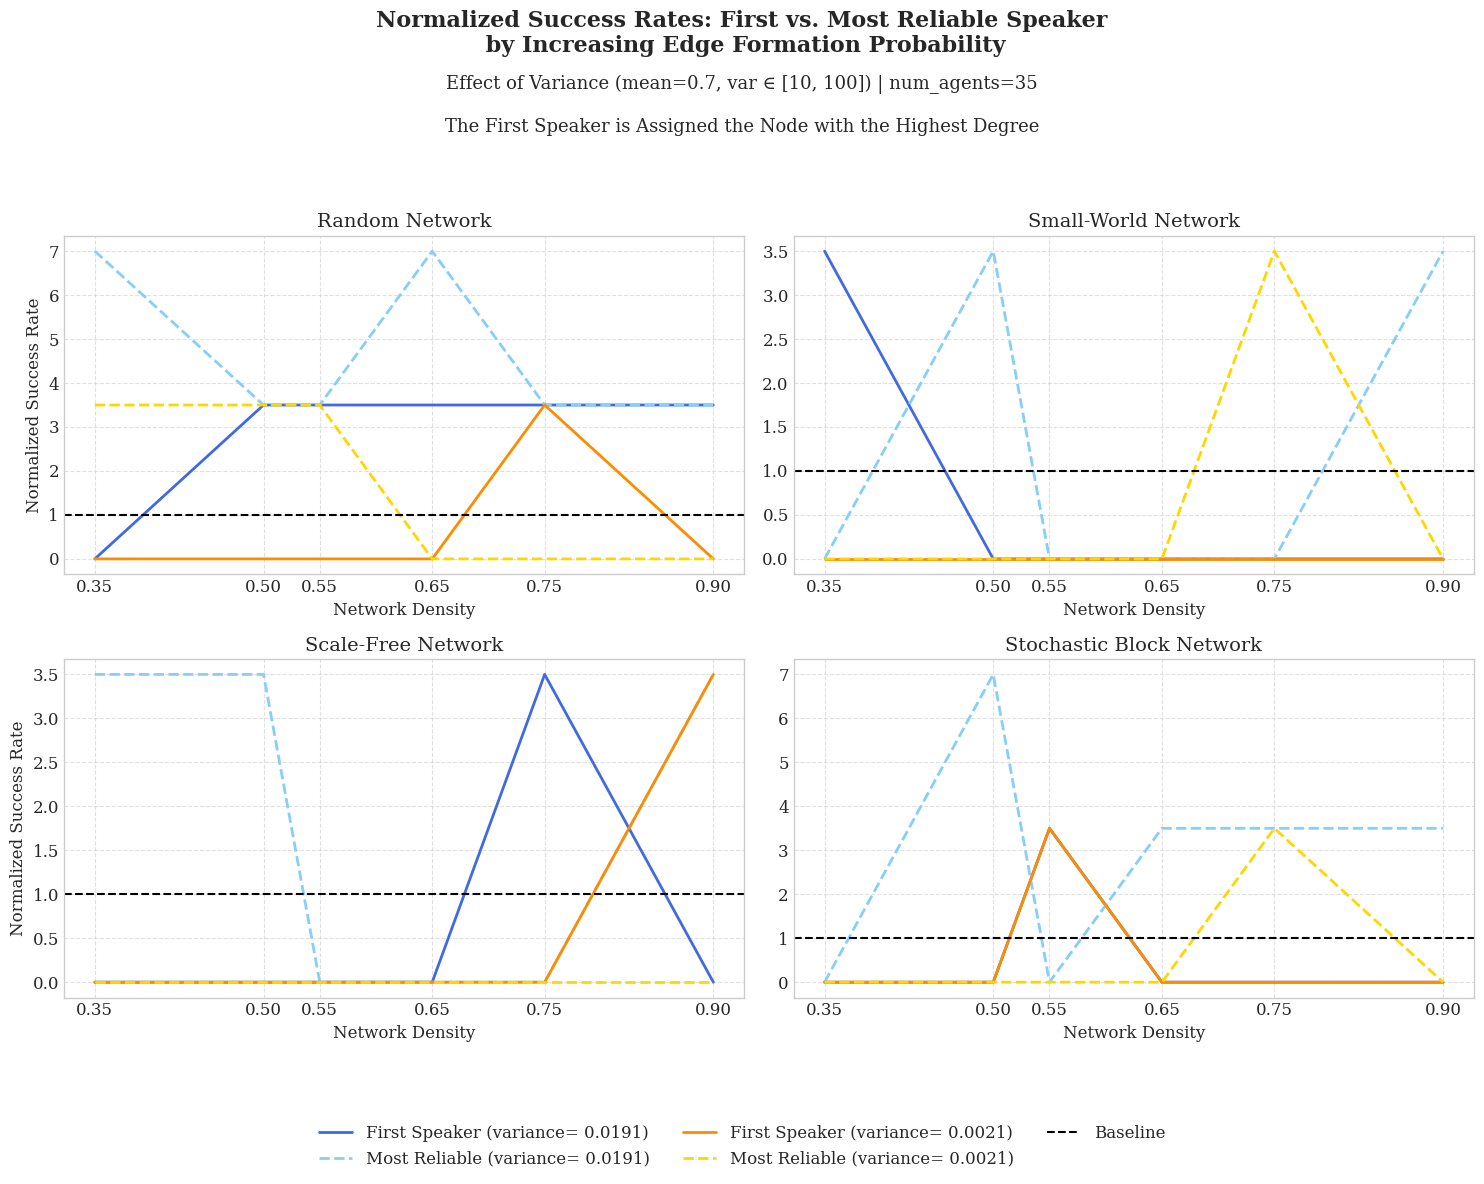

In [31]:
def experiment_by_network_and_p_edge(
    p=0.2,
    p_edge_values=[0.35, 0.4, 0.5, 0.65, 0.7, 0.9],
    group_sizes=[20],
    num_runs=10000,
    beta_mean=0.7,
    beta_variance=[2, 5, 10, 20],
    random_rels=False,
    beta_rels=False,
    peer_rels=True,
    max_rel=0,
    max_steps=1,
    seed=42,
    density=False,
    betweenness=False
):
    import matplotlib.pyplot as plt
    import numpy as np
    from tqdm import tqdm
    from matplotlib import cm

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "mathtext.fontset": "cm"
    })

    network_configs = {
        "Random": {"rn": True, "ws": False, "sf": False, "sblock": False},
        "Small-World": {"rn": False, "ws": True, "sf": False, "sblock": False},
        "Scale-Free": {"rn": False, "ws": False, "sf": True, "sblock": False},
        "Stochastic Block": {"rn": False, "ws": False, "sf": False, "sblock": True}
    }


    network_colors = {
    "Random": "tab:blue",
    "Small-World": "tab:green",
    "Scale-Free": "tab:orange",
    "Stochastic Block": "tab:purple"
    }


    colors_first = ["royalblue", "darkorange"]
    colors_reliable = ["lightskyblue", "gold"]


    var_to_color_first = {k: colors_first[i % len(colors_first)] for i, k in enumerate(beta_variance)}
    var_to_color_reliable = {k: colors_reliable[i % len(colors_reliable)] for i, k in enumerate(beta_variance)}

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    unique_legend = {}

    for ax, (net_name, flags) in zip(axes, network_configs.items()):
        for n in group_sizes:
          true_variance= []

          for k in beta_variance:
            beta_a = beta_mean * k
            beta_b = (1 - beta_mean) * k
            true_var = (beta_a * beta_b) / (((beta_a + beta_b) ** 2) * (beta_a + beta_b + 1))
            true_variance.append(round(true_var, 4))
            normalized_scores = []
            normalized_scores_expert = []


            for p_edge in tqdm(p_edge_values, desc=f"{net_name} | k={k} |Group size {n}"):
                sim = Simulation(
                    num_runs=num_runs,
                    num_agents=n,
                    p_edge=p_edge,
                    p=p,
                    random_rels=random_rels,
                    beta_rels=beta_rels,
                    peer_rels=peer_rels,
                    beta_a=beta_a,
                    beta_b=beta_b,
                    max_steps=max_steps,
                    seed=seed,
                    density=density,
                    betweenness=betweenness,
                    ws=flags["ws"],
                    rn=flags["rn"],
                    sf=flags["sf"],
                    sblock=flags["sblock"],
                    max_rel=max_rel
                )
                sim.run()
                prob_first = sim.get_success_probability()
                prob_expert = sim.get_expert_success_probability()
                norm_score = prob_first / (1 / n)
                norm_expert = prob_expert / (1 / n) if prob_expert > 0 else 0
                normalized_scores.append(norm_score)
                normalized_scores_expert.append(norm_expert)



            color_first = var_to_color_first[k]
            ax.plot(p_edge_values, normalized_scores, label=f"First Speaker (variance= {round(true_var, 4)})", linewidth=2,  linestyle="-", color=color_first)
            color_reliable = var_to_color_reliable[k]
            if beta_rels:
              ax.plot(p_edge_values, normalized_scores_expert, '--', label=f"Most Reliable (variance= {round(true_var, 4)})", linewidth=2, color=color_reliable)  # <-- added


        ax.axhline(y=1.0, color='black', linestyle='--', label='Baseline')

        # Titles and labels
        title = f"{net_name} Network"

        if betweenness:
            sub_title = "\n The First Speaker is Assigned the Node with the Highest Betweenness"
        elif density:
            sub_title = "\nThe First Speaker is Assigned the Node with the Highest Degree"
        else:
            sub_title = "\nThe First Speaker is Assigned a Random Node"

        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Network Density", fontsize=12)
        ax.set_xticks(p_edge_values)
        ax.grid(True, linestyle='--', alpha=0.6)

        if ax in axes[::2]:
            ax.set_ylabel("Normalized Success Rate", fontsize=12)


    handles, labels = [], []
    for a in axes:
        h, l = a.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    fig.legend(
        by_label.values(),
        by_label.keys(),
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=3,
        fontsize=12,
        frameon=False
    )


    if peer_rels:
        main_title = (
            "Normalized Success Rate of First and Most Reliable Speaker\n"
            "for increasing probability values of Edge formation"
        )
        sub_title_main = (
            f"Peer Agents | rel=0.8 | num_agents={group_sizes[0]}\n"
            f"{sub_title}"
        )
    elif beta_rels:
        main_title = (
            "Normalized Success Rates: First vs. Most Reliable Speaker\n"
            " by Increasing Edge Formation Probability"
        )
        sub_title_main = (
            f"Effect of Variance (mean={beta_mean}, var ∈ {beta_variance}) | num_agents={group_sizes[0]}\n"
            f"{sub_title}"
        )
    else:
        main_title = "Normalized Success Rate vs Edge Probability"
        sub_title_main = f"num_agents={group_sizes[0]}"


    plt.suptitle(main_title, fontsize=16, fontweight="bold", y=1.05)

    fig.text(
        0.5,
        0.985,
        sub_title_main,
        ha='center',
        va='top',
        fontsize=13,
        fontweight='normal'
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


experiment_by_network_and_p_edge(
    p=0.2,
    p_edge_values=[0.35, 0.5,0.55, 0.65, 0.75, 0.9],
    group_sizes=[35],
    num_runs=10,
    beta_mean=0.7,
    beta_variance=[10, 100],
    beta_rels=True,
    peer_rels=False,
    max_rel=0,
    density=True,
    betweenness=False
)


<>:127: SyntaxWarning: invalid escape sequence '\c'
<>:127: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-3595965460.py:127: SyntaxWarning: invalid escape sequence '\c'
  fig.text(0.05, 0.50, f"Stochastic Block Model \n {label_A_B} \n {label_x_calc} \n $p_s = x$, $p_d= (0.1)\cdot x$", **fig_kwargs)


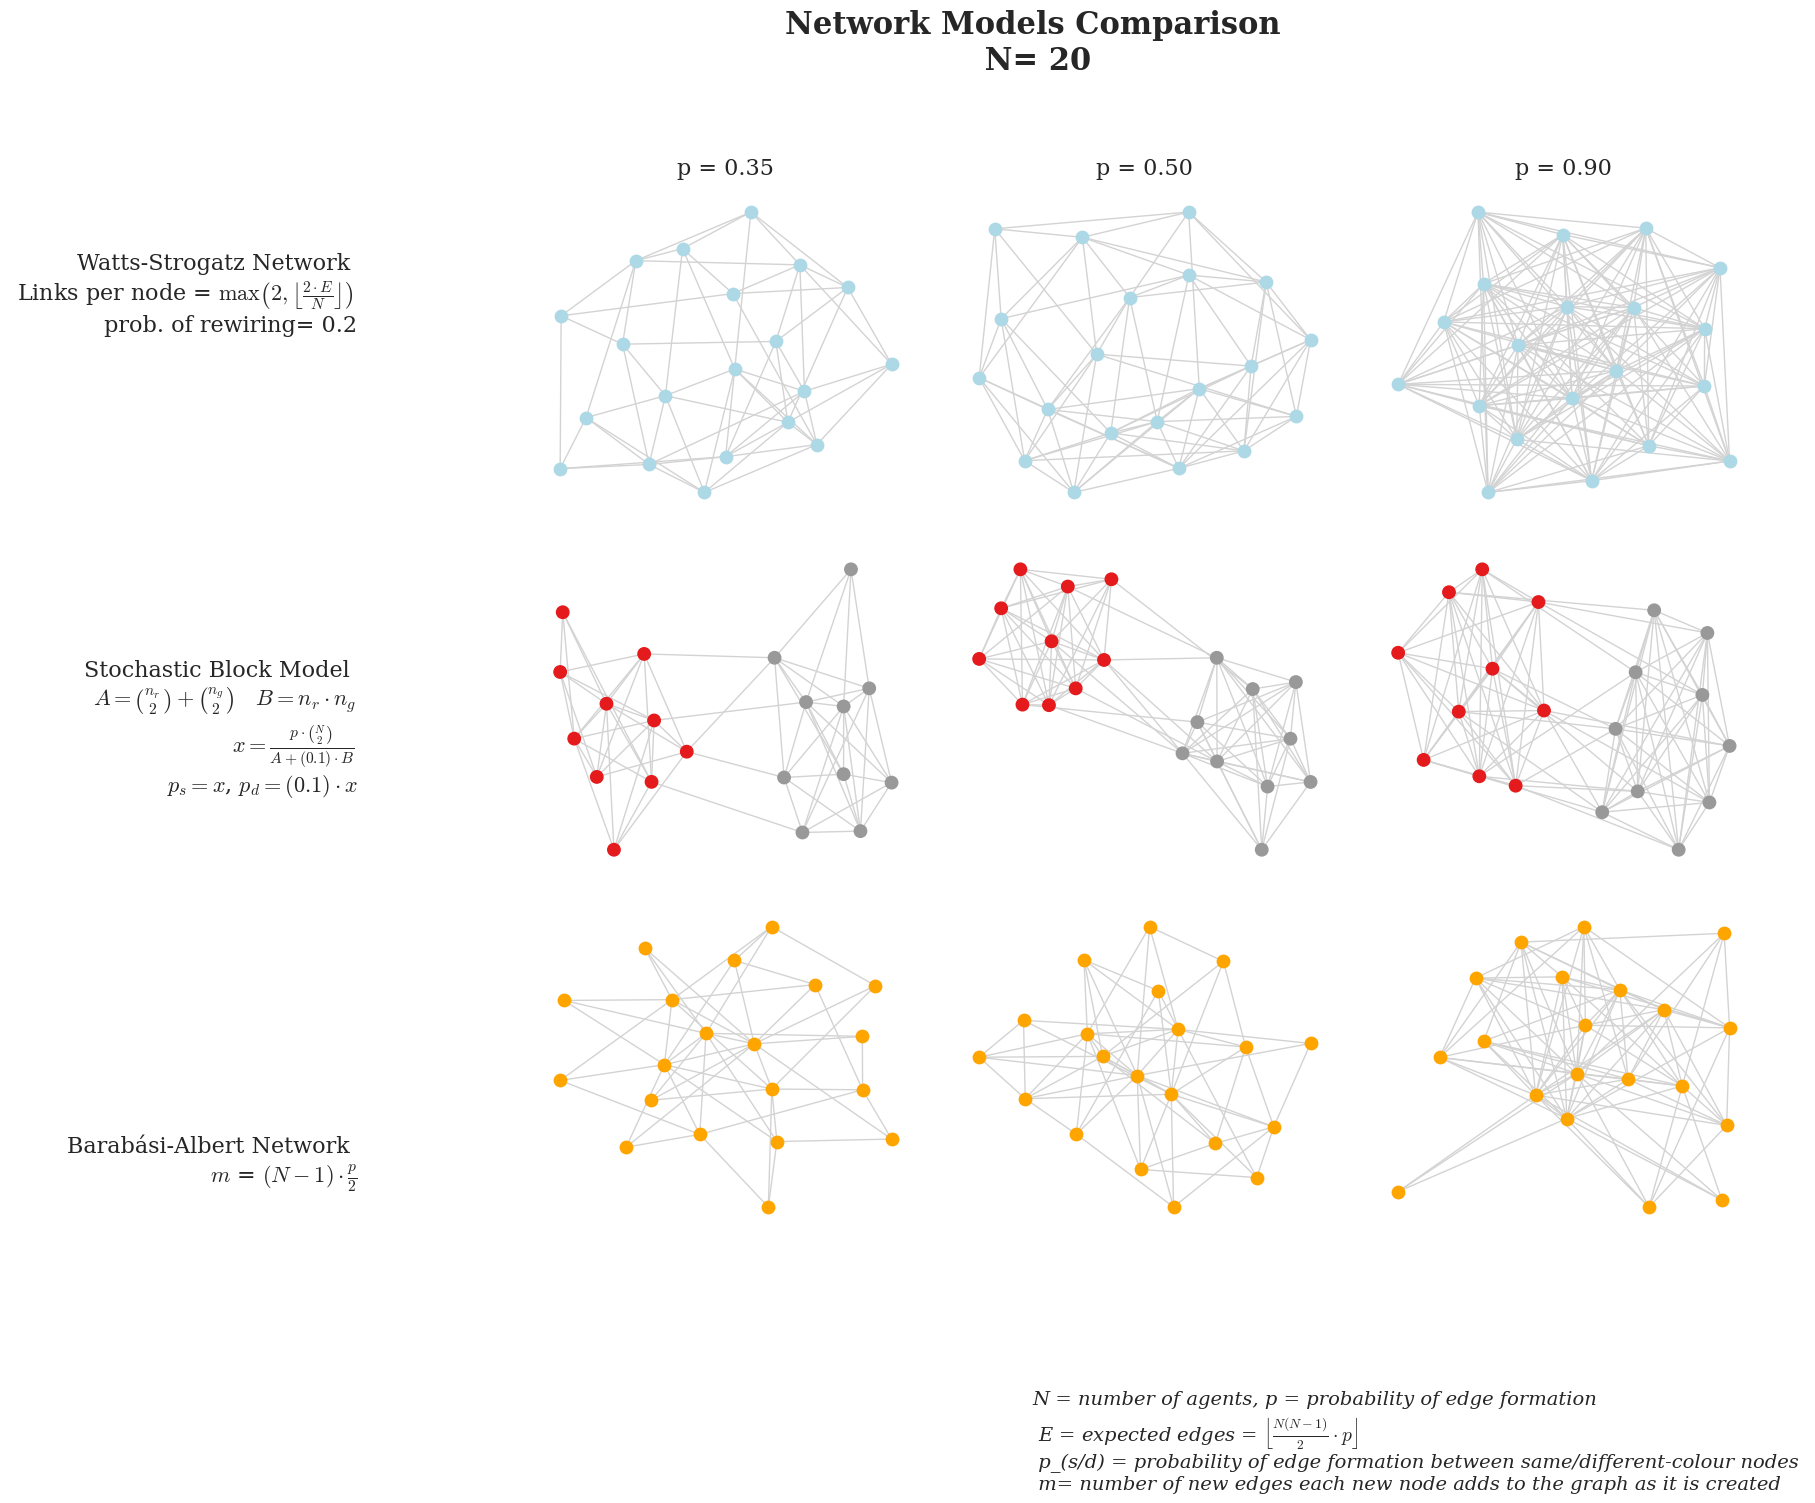

In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Global Parameters
num_agents = 20

p_edge_values = [0.35, 0.50, 0.90]

# Watts-Strogatz  parameters
rewire_prob = 0.2

# Stochastic Block Model parameters
frac = 0.5
sizes_communities = [int(num_agents * frac), int(num_agents * (1 - frac))]
n1, n2 = sizes_communities
N = n1 + n2

colors = []
for i, size in enumerate(sizes_communities):
    colors.extend([i] * size)
ratio = 0.1  # inter/intra ratio


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


k_neighbors_list = []
for j, p_edge in enumerate(p_edge_values):

    # Watts-Strogatz
    ax_ws = axes[0, j]
    expected_edges_ws = int(num_agents * (num_agents - 1) * p_edge / 2)
    k_neighbors = max(2, (2 * expected_edges_ws) // num_agents)
    k_neighbors_list.append(k_neighbors)


    while True:
        G_ws = nx.watts_strogatz_graph(n=num_agents, k=k_neighbors, p=rewire_prob, seed=42)
        if nx.is_connected(G_ws):
            break

    pos_ws = nx.spring_layout(G_ws, seed=42)
    nx.draw(G_ws, pos_ws, ax=ax_ws, node_color="lightblue",
            with_labels=False, node_size=80, edge_color="lightgray")


    #Stochastic Block Model
    ax_sbm = axes[1, j]

    A = (n1*(n1-1)/2 + n2*(n2-1)/2)  # intra pairs
    B = n1*n2                       # inter pairs
    denom = A + ratio*B
    x = p_edge * (N*(N-1)/2) / denom
    p_intra = min(x, 1.0)
    p_inter = min(ratio*x, 1.0)
    m_edges_prob = [
        [p_intra, p_inter],
        [p_inter, p_intra]
    ]

    G_sbm = nx.stochastic_block_model(sizes_communities, m_edges_prob, seed=42)
    pos_sbm = nx.spring_layout(G_sbm, seed=42)
    nx.draw(G_sbm, pos_sbm, ax=ax_sbm, node_color=colors, cmap=plt.cm.Set1,
            with_labels=False, node_size=80, edge_color="lightgray")


    #  Barabási-Albert
    ax_ba = axes[2, j]
    expected_edges_ba = int(num_agents * (num_agents - 1) * p_edge / 2)
    m_edges_ba = max(1, expected_edges_ba // num_agents)

    while True:
        G_ba = nx.barabasi_albert_graph(n=num_agents, m=m_edges_ba, seed=42)
        if nx.is_connected(G_ba):
            break

    pos_ba = nx.spring_layout(G_ba, seed=42)
    nx.draw(G_ba, pos_ba, ax=ax_ba, node_color="orange",
            with_labels=False, node_size=80, edge_color="lightgray")




plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "mathtext.fontset": "cm"
})


for j, p_edge in enumerate(p_edge_values):
    axes[0, j].set_title(f"p = {p_edge:.2f}", fontsize=16)


axes[0, 0].set_ylabel("Watts-Strogatz", fontsize=16, fontweight='bold')
axes[1, 0].set_ylabel("Stochastic Block Model", fontsize=16, fontweight='bold')
axes[2, 0].set_ylabel("Barabási-Albert", fontsize=16, fontweight='bold')


for ax in axes.flatten():
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])


fig.suptitle(f"Network Models Comparison\n N= {num_agents}", fontsize=22, fontweight='bold')

fig_kwargs = {
    'fontsize': 16,
    'ha': 'right',
    'va': 'center'
}

label_expected_edges = r"$\left\lfloor \frac{N(N-1)}{2} \cdot p \right\rfloor$"
label_m = r"$(N-1)\cdot \frac{p}{2}$"
ws_links = r"$\max\left(2, \left\lfloor \frac{2 \cdot E}{N} \right\rfloor\right)$"
label_A_B = r"$A = \binom{n_r}{2} + \binom{n_g}{2} \quad   B = n_r \cdot n_g$"
label_x_calc = r"$x = \frac{p \cdot \binom{N}{2}}{A + (0.1)\cdot B }$"


additional_title = f"N = number of agents, p = probability of edge formation \n E = expected edges = {label_expected_edges} \n p_(s/d) = probability of edge formation between same/different-colour nodes \n m= number of new edges each new node adds to the graph as it is created"

fig.text(0.05, 0.79, f"Watts-Strogatz Network \n Links per node = {ws_links} \n prob. of rewiring= 0.2", **fig_kwargs)

fig.text(0.05, 0.50, f"Stochastic Block Model \n {label_A_B} \n {label_x_calc} \n $p_s = x$, $p_d= (0.1)\cdot x$", **fig_kwargs)

fig.text(0.05, 0.21, f"Barabási-Albert Network \n $m$ = {label_m}", **fig_kwargs)

fig.text(0.5, 0.025, additional_title, ha='left', va='center', fontsize=14, style='italic')

plt.tight_layout(rect=[0.15, 0.15, 1, 0.95])
plt.show()

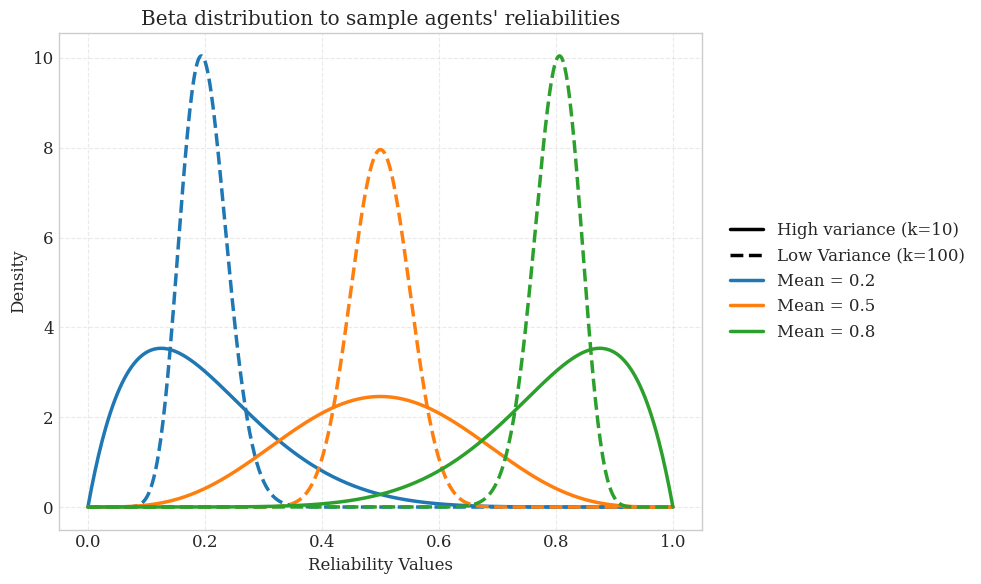

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib.lines import Line2D


beta_mean = [0.2, 0.5, 0.8]
beta_variances = [10, 100]
x = np.linspace(0, 1, 500)


fig, ax = plt.subplots(figsize=(10, 6))


colors = {0.2: 'C0', 0.5: 'C1', 0.8: 'C2'}
linestyles = {10: '-', 100: '--'}


for p in beta_mean:
    for k in beta_variances:
        alpha = p * k
        b = (1 - p) * k
        dist = beta(alpha, b)


        ax.plot(x, dist.pdf(x),
                color=colors[p],
                linestyle=linestyles[k],
                linewidth=2.5)


ax.set_title("Beta distribution to sample agents' reliabilities")
ax.set_xlabel(f"Reliability Values")
ax.set_ylabel("Density")
ax.grid(alpha=0.4, linestyle="--")


legend_handles = [

    Line2D([0], [0], color='black', linestyle='-', lw=2.5,
           label='High variance (k=10)'),
    Line2D([0], [0], color='black', linestyle='--', lw=2.5,
           label='Low Variance (k=100)'),


    Line2D([0], [0], color=colors[0.2], lw=2.5,
           label='Mean = 0.2'),
    Line2D([0], [0], color=colors[0.5], lw=2.5,
           label='Mean = 0.5'),
    Line2D([0], [0], color=colors[0.8], lw=2.5,
           label='Mean = 0.8')
]


ax.legend(handles=legend_handles,
          loc='center left',
          bbox_to_anchor=(1.02, 0.5),
          title="")


fig.tight_layout()
plt.show()

<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-2972452555.py:25: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel(f"Probabilistic Opinion Value \n st. dev. = $k \cdot (1-rel), k=0.5$", fontsize= 20)


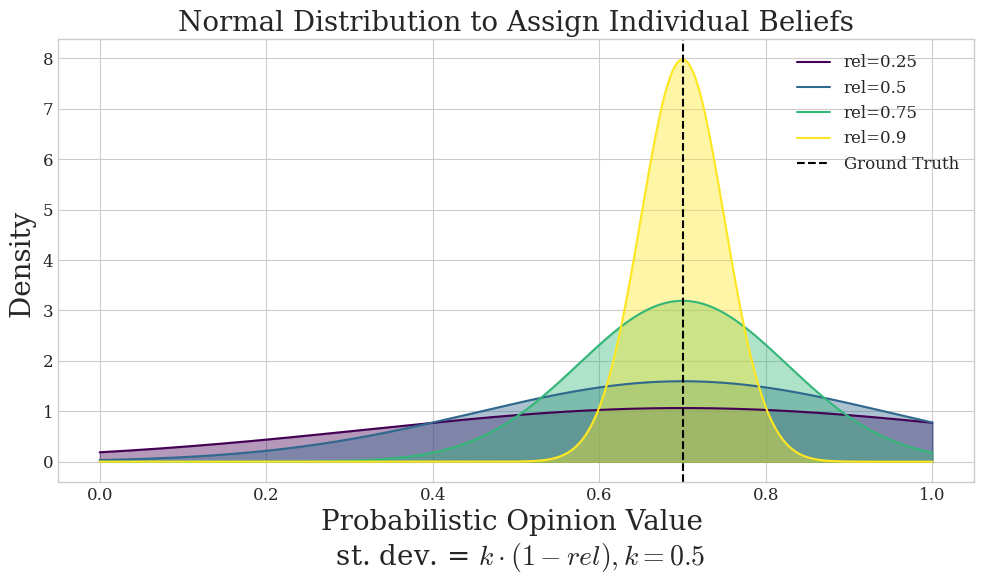

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


ground_truth = 0.7
reliabilities = [0.25, 0.5, 0.75, 0.9]


x = np.linspace(0, 1, 1000)
k = 0.5


plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(reliabilities)))

for i, rel in enumerate(reliabilities):
    std_dev = k * (1 - rel)
    pdf = norm.pdf(x, loc=ground_truth, scale=std_dev)
    plt.plot(x, pdf, label=f"rel={rel}", color=colors[i])
    plt.fill_between(x, pdf, color=colors[i], alpha=0.4)

plt.axvline(ground_truth, color='black', linestyle='--', label=f'Ground Truth')
plt.title(f"Normal Distribution to Assign Individual Beliefs", fontsize = 20)
plt.xlabel(f"Probabilistic Opinion Value \n st. dev. = $k \cdot (1-rel), k=0.5$", fontsize= 20)
plt.ylabel(f"Density ", fontsize = 20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()